In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
#     data_list = [train_sst,train_t300,train_ua,train_va]
#     train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
#     data_list = [train_sst2,train_t3002,train_ua2,train_va2]
#     train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Train samples: 4645, Valid samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(24):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(loss_epoch)),loss_epoch)
        plt.tight_layout()
        plt.show()
        

In [51]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,8))) 
        self.batch_norm = nn.BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True)
#         self.lstm = nn.LSTM(input_size = 1540 * 4, hidden_size = 256, num_layers=2, batch_first=True, bidirectional=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 128))
        self.linear = nn.Linear(128, 24)

    def forward(self, sst, t300, ua, va):
        for conv1 in self.conv1:
            sst = conv1(sst)  # batch * 12 * (24 - 2) * (72 -2)
        for conv2 in self.conv2:
            t300 = conv2(t300)
        for conv3 in self.conv3:
            ua = conv3(ua)
        for conv4 in self.conv4:
            va = conv4(va)

        sst = torch.flatten(sst, start_dim=2)  # batch * 12 * 1540
        t300 = torch.flatten(t300, start_dim=2)
        ua = torch.flatten(ua, start_dim=2)
        va = torch.flatten(va, start_dim=2)  
        
        x = torch.cat([sst, t300, ua, va], dim=-1) # batch * 12 * (1540 * 4)
        x = self.batch_norm(x)
#         x = torch.flatten(x, start_dim=1)
#         x, (h_n, c_n) = self.lstm(x)
#         x = x[:,-1]
        x = self.avgpool(x).squeeze(dim=-2)
        x = self.linear(x)
        return x

In [52]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [53]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 0.021600M


In [54]:
model

CNN_Model(
  (conv1): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (conv4): Sequential(
    (0): Conv2d(12, 12, kernel_size=(4, 8), stride=(1, 1))
  )
  (batch_norm): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 128))
  (linear): Linear(in_features=128, out_features=24, bias=True)
)

acskill_socre:-0.37112388937512664, rmse_score:18.62437371828379
Epoch: 0, Valid Score: -18.995497607658915

Step: 0, Train Loss: 0.6456432342529297
Step: 20, Train Loss: 0.8022929430007935
Step: 40, Train Loss: 0.6507649421691895
Step: 60, Train Loss: 0.604363739490509
Step: 80, Train Loss: 0.4960787892341614
Step: 100, Train Loss: 0.5437449216842651
Step: 120, Train Loss: 0.6494168639183044
Step: 140, Train Loss: 0.7176620960235596
Epoch: 1, Train loss: 0.7099803265643446
acskill_socre:6.482296164915917, rmse_score:18.839636621880093
Epoch: 1, Valid Score: -12.357340456964176
Model saved successfully


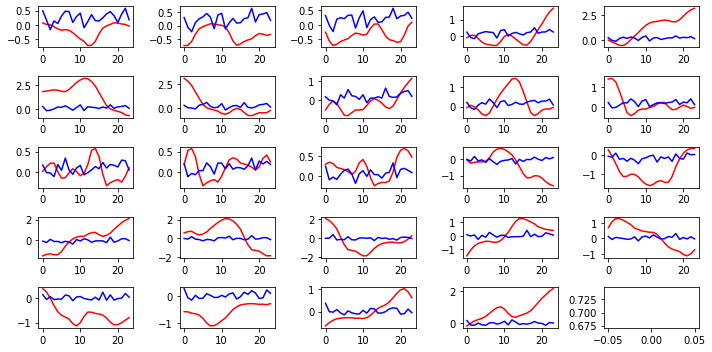

Step: 0, Train Loss: 0.5871274471282959
Step: 20, Train Loss: 0.8067783713340759
Step: 40, Train Loss: 0.6746598482131958
Step: 60, Train Loss: 0.5814543962478638
Step: 80, Train Loss: 0.48175427317619324
Step: 100, Train Loss: 0.6017016768455505
Step: 120, Train Loss: 0.7354286909103394
Step: 140, Train Loss: 0.46086177229881287
Epoch: 2, Train loss: 0.6413299551565353
acskill_socre:11.422237975203032, rmse_score:18.697173273300848
Epoch: 2, Valid Score: -7.274935298097816
Model saved successfully


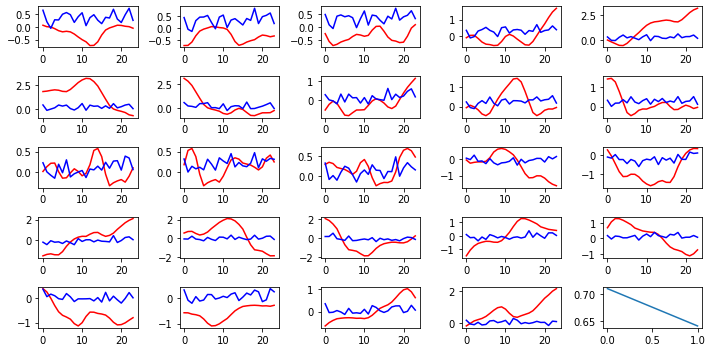

Step: 0, Train Loss: 0.707396388053894
Step: 20, Train Loss: 0.46275627613067627
Step: 40, Train Loss: 0.6270951628684998
Step: 60, Train Loss: 0.7026209235191345
Step: 80, Train Loss: 0.6482803225517273
Step: 100, Train Loss: 0.634793758392334
Step: 120, Train Loss: 0.5128964185714722
Step: 140, Train Loss: 0.4865262508392334
Epoch: 3, Train loss: 0.59986074309643
acskill_socre:15.937884702946327, rmse_score:18.315124344930044
Epoch: 3, Valid Score: -2.377239641983717
Model saved successfully


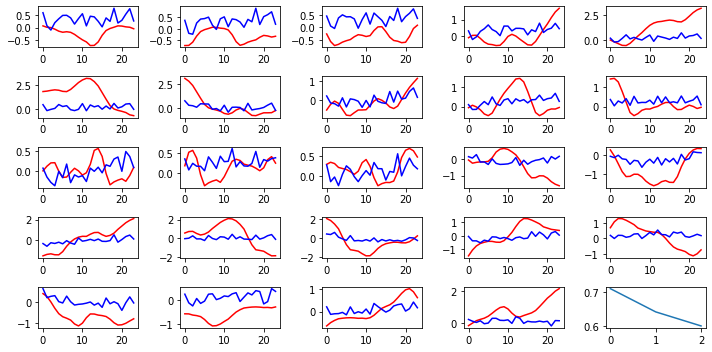

Step: 0, Train Loss: 0.5906418561935425
Step: 20, Train Loss: 0.49125874042510986
Step: 40, Train Loss: 0.5954432487487793
Step: 60, Train Loss: 0.527991533279419
Step: 80, Train Loss: 0.6385406255722046
Step: 100, Train Loss: 0.546643853187561
Step: 120, Train Loss: 0.5243262648582458
Step: 140, Train Loss: 0.7295109629631042
Epoch: 4, Train loss: 0.5629468679632226
acskill_socre:18.708524861682434, rmse_score:18.01289892236193
Epoch: 4, Valid Score: 0.6956259393205038
Model saved successfully


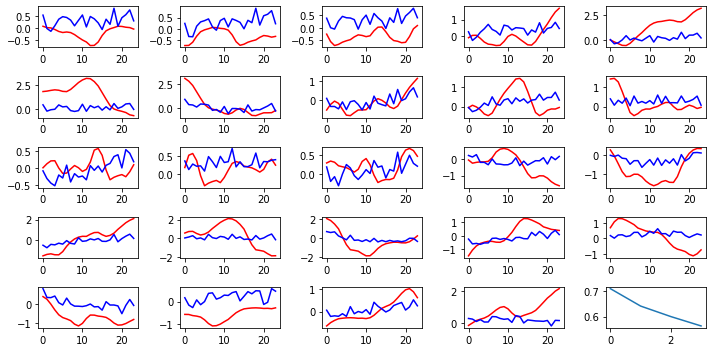

Step: 0, Train Loss: 0.5784971117973328
Step: 20, Train Loss: 0.39671921730041504
Step: 40, Train Loss: 0.5891592502593994
Step: 60, Train Loss: 0.4752352237701416
Step: 80, Train Loss: 0.34579846262931824
Step: 100, Train Loss: 0.7424219846725464
Step: 120, Train Loss: 0.5388319492340088
Step: 140, Train Loss: 0.46918439865112305
Epoch: 5, Train loss: 0.5427544417038356
acskill_socre:19.91394358270157, rmse_score:17.85330474914893
Epoch: 5, Valid Score: 2.060638833552641
Model saved successfully


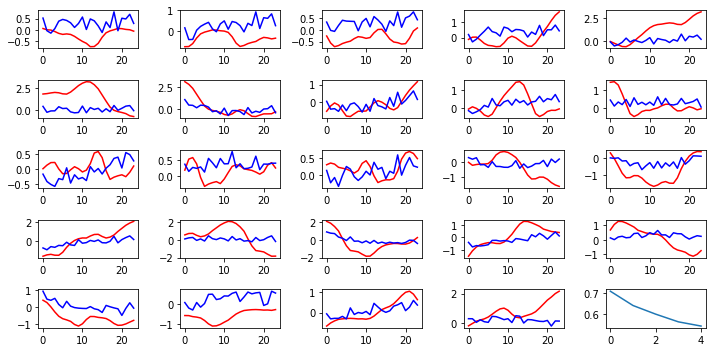

Step: 0, Train Loss: 0.5137909054756165
Step: 20, Train Loss: 0.5910803079605103
Step: 40, Train Loss: 0.46649906039237976
Step: 60, Train Loss: 0.533586859703064
Step: 80, Train Loss: 0.4959256649017334
Step: 100, Train Loss: 0.5506114363670349
Step: 120, Train Loss: 0.5533899664878845
Step: 140, Train Loss: 0.48399099707603455
Epoch: 6, Train loss: 0.5269001379404983
acskill_socre:20.716447099890065, rmse_score:17.73150215648404
Epoch: 6, Valid Score: 2.984944943406024
Model saved successfully


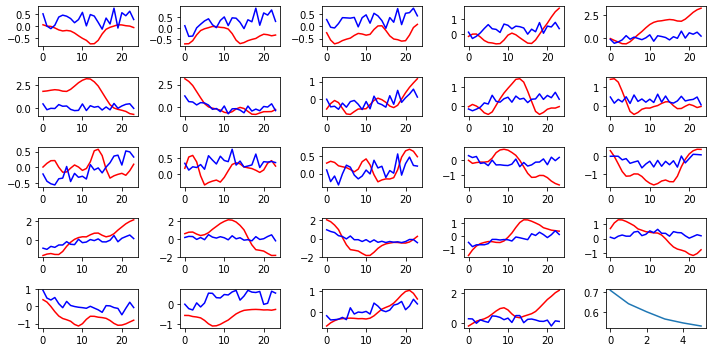

Step: 0, Train Loss: 0.3772215247154236
Step: 20, Train Loss: 0.36891970038414
Step: 40, Train Loss: 0.578740656375885
Step: 60, Train Loss: 0.596505880355835
Step: 80, Train Loss: 0.5223549008369446
Step: 100, Train Loss: 0.46012255549430847
Step: 120, Train Loss: 0.6078292727470398
Step: 140, Train Loss: 0.4427790641784668
Epoch: 7, Train loss: 0.5157757605591865
acskill_socre:21.88179054088653, rmse_score:17.61649547263421
Epoch: 7, Valid Score: 4.265295068252321
Model saved successfully


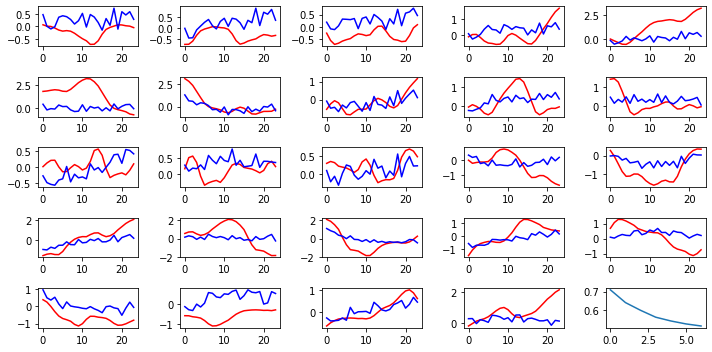

Step: 0, Train Loss: 0.3791884183883667
Step: 20, Train Loss: 0.6068877577781677
Step: 40, Train Loss: 0.6939670443534851
Step: 60, Train Loss: 0.5681044459342957
Step: 80, Train Loss: 0.44139647483825684
Step: 100, Train Loss: 0.43447041511535645
Step: 120, Train Loss: 0.6404438614845276
Step: 140, Train Loss: 0.8084894418716431
Epoch: 8, Train loss: 0.5073263065455711
acskill_socre:22.199099479754096, rmse_score:17.544574649086055
Epoch: 8, Valid Score: 4.654524830668041
Model saved successfully


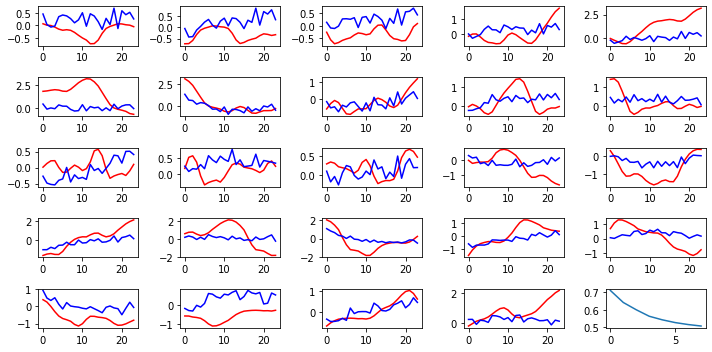

Step: 0, Train Loss: 0.5418800115585327
Step: 20, Train Loss: 0.5457397699356079
Step: 40, Train Loss: 0.5232147574424744
Step: 60, Train Loss: 0.36878329515457153
Step: 80, Train Loss: 0.3731873035430908
Step: 100, Train Loss: 0.5461697578430176
Step: 120, Train Loss: 0.6581246852874756
Step: 140, Train Loss: 0.3729647994041443
Epoch: 9, Train loss: 0.500564936905691
acskill_socre:22.27426145102752, rmse_score:17.538188552565423
Epoch: 9, Valid Score: 4.736072898462098
Model saved successfully


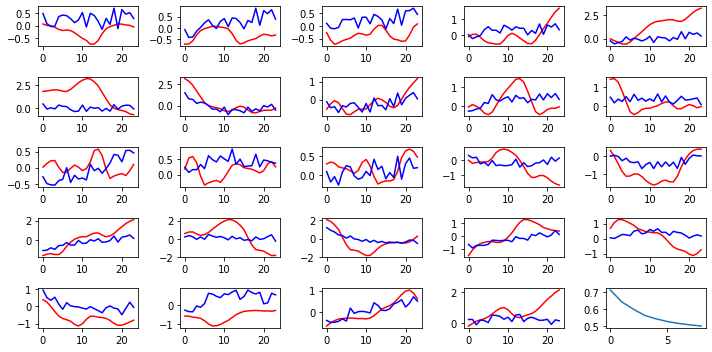

Step: 0, Train Loss: 0.6028610467910767
Step: 20, Train Loss: 0.5593138337135315
Step: 40, Train Loss: 0.47284913063049316
Step: 60, Train Loss: 0.49785035848617554
Step: 80, Train Loss: 0.3933200240135193
Step: 100, Train Loss: 0.39926522970199585
Step: 120, Train Loss: 0.413756787776947
Step: 140, Train Loss: 0.5278652906417847
Epoch: 10, Train loss: 0.49493833763958656
acskill_socre:22.719417000149285, rmse_score:17.457931713156153
Epoch: 10, Valid Score: 5.261485286993132
Model saved successfully


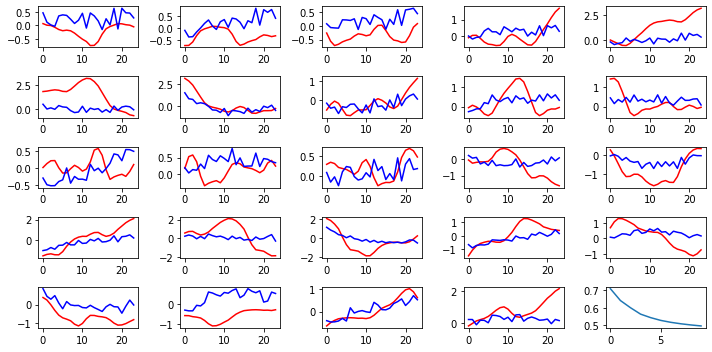

Step: 0, Train Loss: 0.5870427489280701
Step: 20, Train Loss: 0.5068688988685608
Step: 40, Train Loss: 0.47554391622543335
Step: 60, Train Loss: 0.4752275347709656
Step: 80, Train Loss: 0.49892377853393555
Step: 100, Train Loss: 0.47114211320877075
Step: 120, Train Loss: 0.4032982587814331
Step: 140, Train Loss: 0.35499200224876404
Epoch: 11, Train loss: 0.49245486418678336
acskill_socre:22.704278018728548, rmse_score:17.452738233011626
Epoch: 11, Valid Score: 5.251539785716922


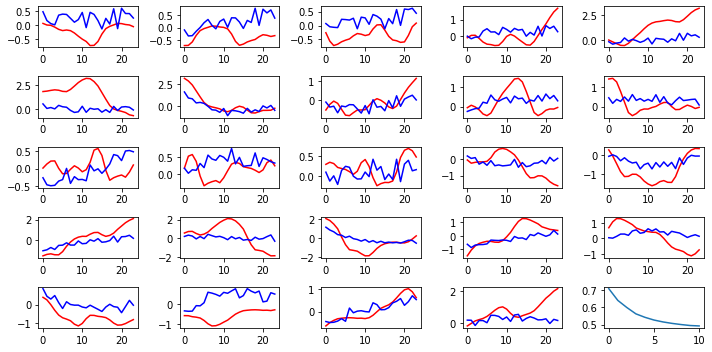

Step: 0, Train Loss: 0.5029906630516052
Step: 20, Train Loss: 0.4209625720977783
Step: 40, Train Loss: 0.49894770979881287
Step: 60, Train Loss: 0.39693373441696167
Step: 80, Train Loss: 0.3984209895133972
Step: 100, Train Loss: 0.5821952819824219
Step: 120, Train Loss: 0.573753833770752
Step: 140, Train Loss: 0.5554801821708679
Epoch: 12, Train loss: 0.48806736322298444
acskill_socre:23.02733605144342, rmse_score:17.421050962332856
Epoch: 12, Valid Score: 5.606285089110564
Model saved successfully


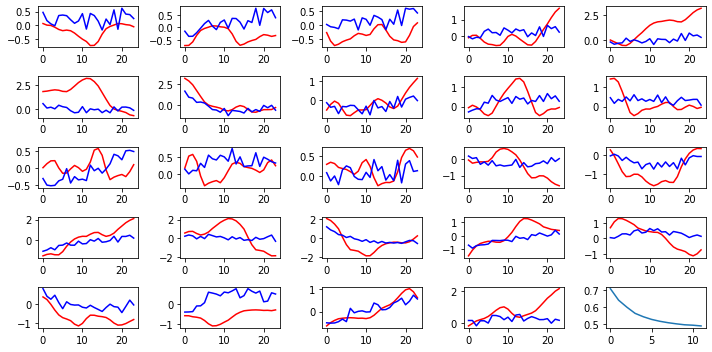

Step: 0, Train Loss: 0.35318809747695923
Step: 20, Train Loss: 0.47229331731796265
Step: 40, Train Loss: 0.5247604846954346
Step: 60, Train Loss: 0.5230209827423096
Step: 80, Train Loss: 0.48827967047691345
Step: 100, Train Loss: 0.4146385192871094
Step: 120, Train Loss: 0.4361593723297119
Step: 140, Train Loss: 0.4590788781642914
Epoch: 13, Train loss: 0.4850527219576378
acskill_socre:23.044478949331243, rmse_score:17.390142688090606
Epoch: 13, Valid Score: 5.654336261240637
Model saved successfully


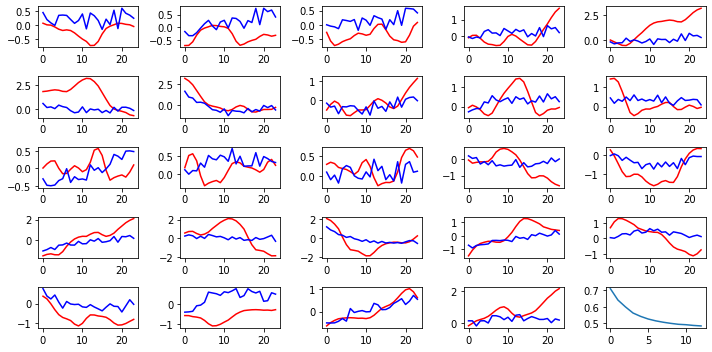

Step: 0, Train Loss: 0.4807625710964203
Step: 20, Train Loss: 0.4969361424446106
Step: 40, Train Loss: 0.5808049440383911
Step: 60, Train Loss: 0.5817725658416748
Step: 80, Train Loss: 0.36770710349082947
Step: 100, Train Loss: 0.4336380660533905
Step: 120, Train Loss: 0.4273802638053894
Step: 140, Train Loss: 0.3247604966163635
Epoch: 14, Train loss: 0.48003988008793086
acskill_socre:22.970629468930074, rmse_score:17.403138965353847
Epoch: 14, Valid Score: 5.567490503576227


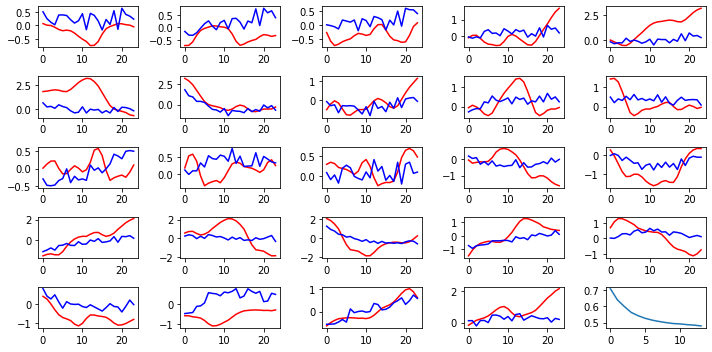

Step: 0, Train Loss: 0.5112681984901428
Step: 20, Train Loss: 0.47283124923706055
Step: 40, Train Loss: 0.42858263850212097
Step: 60, Train Loss: 0.3905293345451355
Step: 80, Train Loss: 0.3882666826248169
Step: 100, Train Loss: 0.3853563666343689
Step: 120, Train Loss: 0.4827463626861572
Step: 140, Train Loss: 0.4469776153564453
Epoch: 15, Train loss: 0.4828402046879677
acskill_socre:23.047669160292006, rmse_score:17.355975777210425
Epoch: 15, Valid Score: 5.6916933830815815
Model saved successfully


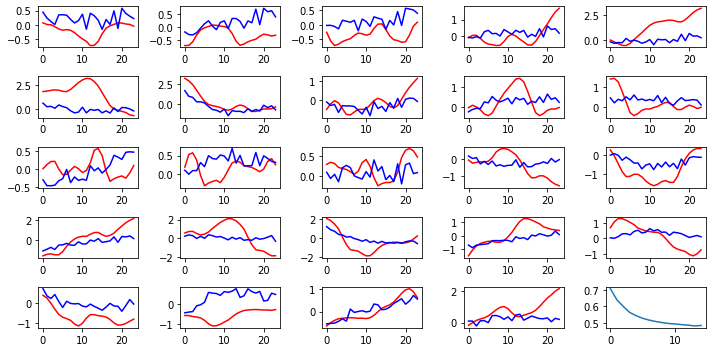

Step: 0, Train Loss: 0.5639479160308838
Step: 20, Train Loss: 0.543636679649353
Step: 40, Train Loss: 0.4506112337112427
Step: 60, Train Loss: 0.5119678378105164
Step: 80, Train Loss: 0.37069523334503174
Step: 100, Train Loss: 0.433552622795105
Step: 120, Train Loss: 0.4576043486595154
Step: 140, Train Loss: 0.3982175290584564
Epoch: 16, Train loss: 0.47937355711035534
acskill_socre:23.059723362101394, rmse_score:17.354141650197977
Epoch: 16, Valid Score: 5.705581711903417
Model saved successfully


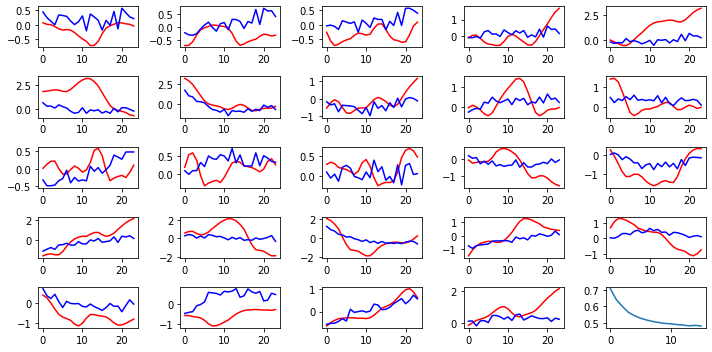

Step: 0, Train Loss: 0.41727524995803833
Step: 20, Train Loss: 0.5232516527175903
Step: 40, Train Loss: 0.5477050542831421
Step: 60, Train Loss: 0.47138190269470215
Step: 80, Train Loss: 0.4902176260948181
Step: 100, Train Loss: 0.533722996711731
Step: 120, Train Loss: 0.39752352237701416
Step: 140, Train Loss: 0.4720103144645691
Epoch: 17, Train loss: 0.4736023326850917
acskill_socre:23.23068668397888, rmse_score:17.34390443600535
Epoch: 17, Valid Score: 5.886782247973532
Model saved successfully


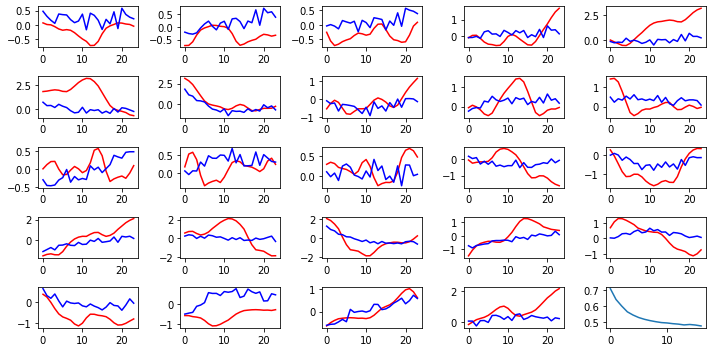

Step: 0, Train Loss: 0.33456867933273315
Step: 20, Train Loss: 0.5016660690307617
Step: 40, Train Loss: 0.3898574709892273
Step: 60, Train Loss: 0.6748091578483582
Step: 80, Train Loss: 0.5425950288772583
Step: 100, Train Loss: 0.5807470083236694
Step: 120, Train Loss: 0.5529650449752808
Step: 140, Train Loss: 0.35534748435020447
Epoch: 18, Train loss: 0.472766613919441
acskill_socre:23.13275588012973, rmse_score:17.312505075978326
Epoch: 18, Valid Score: 5.820250804151403


In [ ]:
train(num_epochs=50)

In [ ]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [16]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [17]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [18]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [19]:
make_zip()